In [82]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import *
from typing import Any, List, Tuple
import scipy.integrate as integrate
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
sys.path.insert(1, '/Users/niyi/Documents/GitHub/Optimal-Control/Code/Systems')
from EnforceTyping import enforce_method_typing
from ParticlesandFields import Field, ClassicalParticle, ParticleInField
from MDPFramework import MDPEnvironment, MDPController, LearningAgent

In [83]:
coulomb_constant = 8.9875e9  # N*m^2/C^2
@dataclass(kw_only=True)
class ElectrostaticField2D(Field):
  """
  A class used to represent a 2D Electrostatic Field

  Attributes
  ----------
  field_sources: dict
      a formatted string to print out what the animal says
  dimensionality: tuple
      a tuple of the dimensionality of the field  

  Methods
  -------
  dynamics(self, observation_position: np.ndarray, time: float) -> np.ndarray:
      Represents the value of the field at any given point(s) or time. 
  potential(self, observation_position: np.ndarray, time: float) -> float:
      Represents the potential due to the field at a given position and/or time  
  potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray, time: float) -> float:
      Represents the potential difference between two positions at a given time in the vector field   
  gradient(self, observation_position: np.ndarray, time: float) -> float:
      Represents the gradient at a given position and/or time in the vector field 
  curl(self, observation_position: np.ndarray, time: float) -> float:
      Represents the curl at a given position and/or time in the vector field 
  divergence(self, observation_position: np.ndarray, time: float) -> float:
      Represents the divergence at a given position and/or time in the vector field
  """
  field_sources: dict
  dimensionality: tuple = (2,)

  def __call__(self, observation_position: np.ndarray) -> np.ndarray:
      return self.dynamics(observation_position)

  def __post_init__(self):
    assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
    for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
        assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle" 

  @enforce_method_typing
  def dynamics(self, observation_position: np.ndarray) -> np.ndarray:
      """
      This function outputs the field strength due to field sources experienced at any given point(s) or time. 
      This determines the physics of the field (a 2D Electricstatic Field in this case)

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric field strength vector at the given position.
      """
      electric_field_vector = np.zeros_like(observation_position)
      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_vectors = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vectors = observation_position - position_vectors
          displacement_magnitude = np.linalg.norm(displacement_vectors, axis=0)
          electric_field_vector += (displacement_vectors * field_source.charge) / displacement_magnitude**3
      electric_field_vector = coulomb_constant * electric_field_vector
      return np.round(electric_field_vector, 3)  # N/C or V/m

  @enforce_method_typing
  def potential(self, observation_position: np.ndarray) -> float:
      """
      Calculate the potential (voltage) at a position in the field.

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric potential at the given position.
      """
      electric_potential = 0.0
      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_vectors = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vectors = observation_position - position_vectors
          displacement_magnitude = np.linalg.norm(displacement_vectors, axis=0)
          electric_potential += field_source.charge / displacement_magnitude
      electric_potential = coulomb_constant * electric_potential
      return np.round(electric_potential, 3)  # V

  @enforce_method_typing
  def potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray) -> float:
    """
    Calculate the potential difference between the initial position and the final position in the field.

    Args:
        initial_position (np.ndarray): The starting position.
        final_position (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    assert initial_position.shape == self.dimensionality, "initial_position has the wrong dimensions"
    assert final_position.shape == self.dimensionality, "final_position has the wrong dimensions"
    PorentialDifference= self.potential(initial_position)- self.potential(final_position)
    return PorentialDifference

  @enforce_method_typing
  def gradient(self, observation_position: np.ndarray, delta: float= 0.001)->np.ndarray:
    """
    This function returns the derivative of the field at a given point

    Args:
        observation_position (np.ndarray): The position.
        delta (float, optional): The step size. Defaults to 0.001.

    Returns: 
      np.ndarray: The gradient of the field at the given position.
    """
    gradient= np.zeros_like(observation_position)
    for i in range(len(observation_position)):
      di= np.zeros_like(observation_position)
      di[i, ] = di[i, ]+delta
      plusdi= observation_position+ di
      minusdi= observation_position- di
      gradient[i]= (self.dynamics(plusdi)- self.dynamics(minusdi))[i]/ (2* delta)
    return gradient

  @enforce_method_typing
  def plot_field(self, low_bound= -5, high_bound= 5, n_vectors= 50):
    """
    This function plots the 2D electric vector field

    Args:
    low_bound (float, optional): The lower bound of the plot. Defaults to -5.
    high_bound (float, optional): The upper bound of the plot. Defaults to 5.
    n_vectors (int, optional): The number of vectors to plot. Defaults to 50.

    """
    observation_position= np.meshgrid(np.linspace(low_bound, high_bound, n_vectors), 
                                    np.linspace(low_bound, high_bound, n_vectors))
    observation_position= np.stack(observation_position)
    xd, yd = self.dynamics(observation_position)
    xd = xd / np.sqrt(xd**2 + yd**2)
    yd = yd / np.sqrt(xd**2 + yd**2)
    color_aara = np.sqrt(xd**2+ yd**2)
    fig, ax = plt.subplots(1,1)
    cp = ax.quiver(observation_position[0],observation_position[1],xd,yd,color_aara)
    fig.colorbar(cp)
    plt.rcParams['figure.dpi'] = 150
    plt.show()

In [84]:
negative_charge= ClassicalParticle(mass=1e-14, charge= -1e-9)
positive_charge= ClassicalParticle(mass=1e-14, charge= 1e-9)
sources = {"Particle": [negative_charge, positive_charge],
           "Position": [np.array([1.0, 1.0]), np.array([-1.0, 1.0])]} 

test_electric_field= ElectrostaticField2D(field_sources=sources)


**1. Unit tests**

Unit tests are very low level and close to the source of an application. They consist in testing individual methods and functions of the classes, components, or modules used by your software. Unit tests are generally quite cheap to automate and can run very quickly by a continuous integration server.



In [85]:
point_charge_in_electric_field= ParticleInField(field=test_electric_field, 
                                               particle=positive_charge, 
                                               target=np.array([0.0, 0.0]))


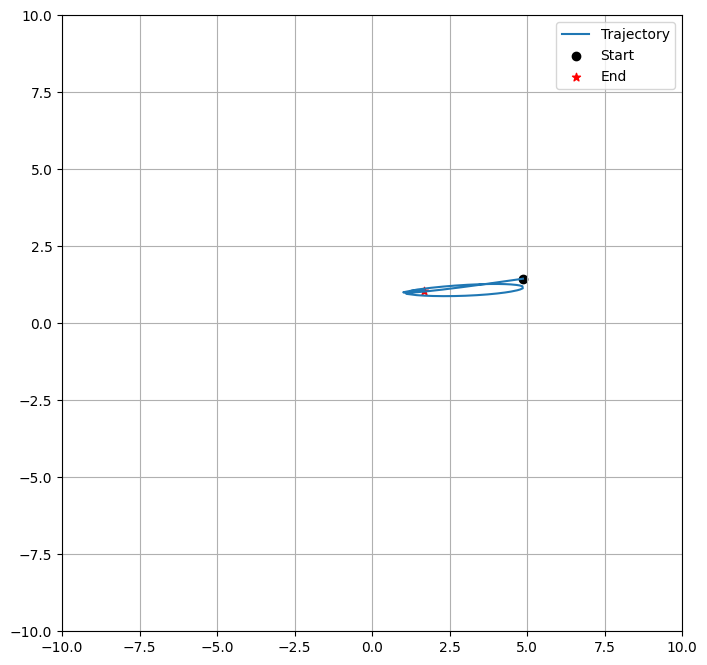

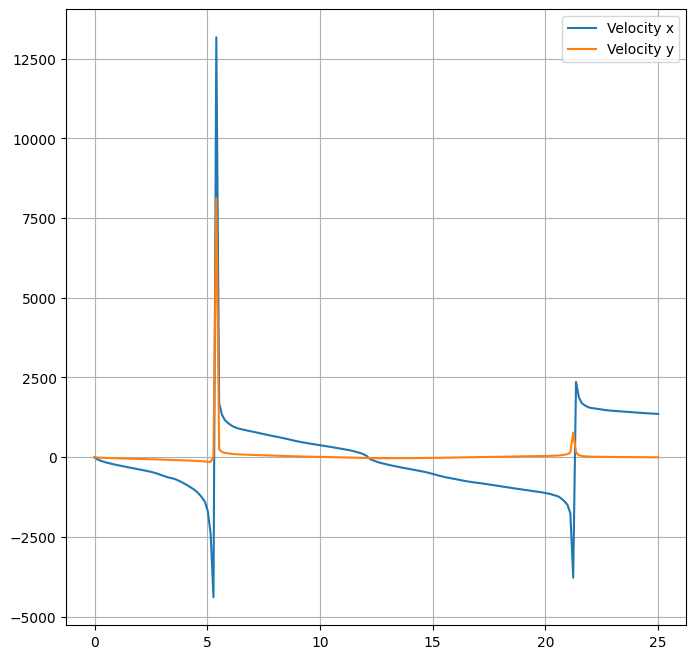

-199996.90785232888

In [86]:
state_trajectory, trajectory_return, time= point_charge_in_electric_field.sample_trajectory(25.0)
point_charge_in_electric_field.plot_trajectory(state_trajectory, time)
trajectory_return

**2. Integration tests**

Integration tests verify that different modules or services used by your application work well together. For example, it can be testing the interaction with the database or making sure that microservices work together as expected. These types of tests are more expensive to run as they require multiple parts of the application to be up and running.



/Users/niyi/Documents/GitHub/Optimal-Control/Code/Systems/ParticlesandFields.py:131: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  next_state_vector = integrate.odeint(self.state_dynamics, state.vector(), time_span, args=(control,))[-1]


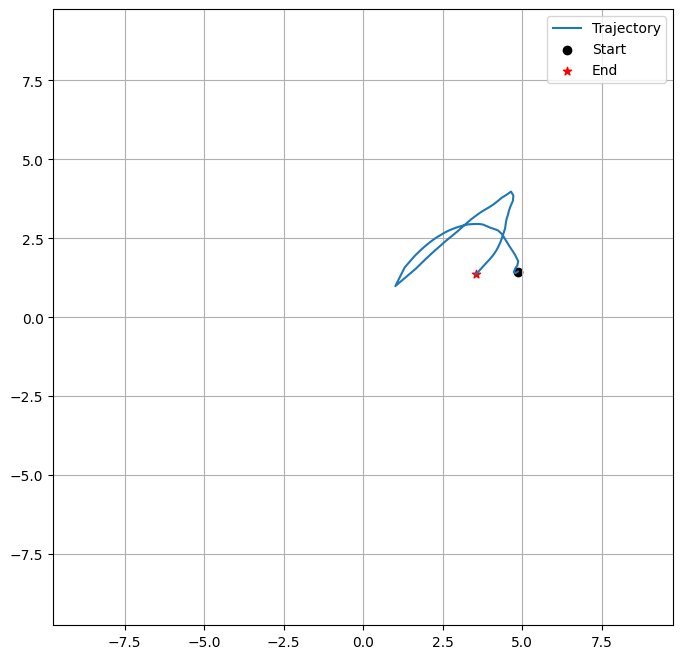

(RandomPolicy(action_dims=(2,), control_magnitude=1e-09), -99998.64612588559)

In [88]:
@dataclass
class RandomPolicy:
  action_dims: tuple
  control_magnitude: float

  def __call__(self, observation: np.ndarray):
    return self.control_magnitude* (2*np.random.ranf(self.action_dims)-1)
    
@dataclass
class RandomController(MDPController):
  
  @property
  def policy(self):
      return RandomPolicy(action_dims=self.environment.action_dims, control_magnitude=1e-9)
  
  @enforce_method_typing
  def act(self, observation: np.ndarray)-> np.ndarray:
      action= self.policy(observation)
      return action
  
  def observe(self, state)-> np.ndarray:
      observation= state.vector()
      return observation
  
  def sample_trajectory(self, runtime: float, n_steps: int=100):
      trajectory= []
      trajectory_return= 0.0
      time= 0.0
      state= self.environment.initial_state
      time_interval= runtime/n_steps
      time_span = np.linspace(time, runtime, n_steps)
      for _ in time_span:
          observation= self.observe(state)
          trajectory.append(observation)
          action= self.act(observation)
          state, reward, _= self.environment.transition_step(state, action, time_interval)
          trajectory_return += reward
      return trajectory, trajectory_return
  
  def plot_trajectory(self, trajectory):
    trajectory= np.array(trajectory)
    px, py, vx, vy= trajectory.transpose()
    plt.figure(figsize=(8, 8))
    plt.plot(px, py, label='Trajectory')
    plt.scatter(px[0], py[0], c='k', marker='o', label='Start')
    plt.scatter(px[-1], py[-1], c='r', marker='*', label='End')
    xmax= max(abs(px))
    ymax= max(abs(py))
    true_max= max((xmax, ymax))
    plt.xlim(-2*true_max, 2*true_max)
    plt.ylim(-2*true_max, 2*true_max)
    plt.grid(True)
    plt.legend()
    plt.show()

RandomWalker= RandomController(environment=point_charge_in_electric_field)
test_trajectory, test_trajectory_return= RandomWalker.sample_trajectory(5)
RandomWalker.plot_trajectory(test_trajectory)
test_trajectory_return

**3. Functional tests**
Functional tests focus on the application requirements of the code. Functional tests are performed to check if this module functions as intended.They only verify the output of an action and do not check the intermediate states of the system when performing that action. 

**4. Performance testing**
Performance tests help to measure the reliability, speed, scalability, and responsiveness of an application. It can determine if an application meets performance requirements, locate bottlenecks, measure stability during peak traffic, and more.